In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pydot
import graphviz
from src.network import TableNet

Paper: https://arxiv.org/abs/2001.01469

### Data

#### Train data
We first train and test our model using the same Marmot dataset as the original TableNet Paper:
 
https://www.icst.pku.edu.cn/cpdp/sjzy/index.htm.

We also use the proposed column annotation in the paper. The annotated data with column labelling can be found in: 
https://drive.google.com/drive/folders/1QZiv5RKe3xlOBdTzuTVuYRxixemVIODp.



#### Transfer learning 

Following our previous research and experiment, we can then apply this pre-trained model on our FinTabNet dataset: 

https://developer.ibm.com/exchanges/data/all/fintabnet/. 

The annotation for FinTabNet dataset is originally in json. However, one may easily label and convert the labeled data using: 

https://github.com/tzutalin/labelImg 


In [2]:
# Generate Table and Column Mask
# from data_preprocess import generate_mask
!python3 data_preprocess/generate_mask.py

In [3]:
list_ds = tf.data.Dataset.list_files('./dataset/Marmot_data/*.xml')

2022-04-07 01:29:22.804513: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-04-07 01:29:23.492057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 01:29:23.492713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-04-07 01:29:23.493050: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/

In [4]:
img_height, img_width = 256, 256

def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image


def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_bmp(img, channels=4)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def decode_mask_img(img):
  # convert the compressed string to a 2D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=1)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
  file_path = tf.strings.regex_replace(file_path, '.xml', '.bmp')

  mask_file_path = tf.strings.regex_replace(file_path, '.bmp', '.jpeg')

  table_mask_file_path = tf.strings.regex_replace(mask_file_path, 'Marmot_data', 'table_mask')
  column_mask_file_path = tf.strings.regex_replace(mask_file_path, 'Marmot_data', 'column_mask')

  img = normalize(decode_img(tf.io.read_file(file_path)))
  table_mask = normalize(decode_mask_img(tf.io.read_file(table_mask_file_path)))
  column_mask = normalize(decode_mask_img(tf.io.read_file(column_mask_file_path)))

  return img[:,:,:-1], {"table_output" : table_mask, "column_output" : column_mask }

In [5]:
# dataset = list_ds.map(process_path)

DATASET_SIZE = len(list(list_ds))
train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

train = list_ds.take(train_size)
test = list_ds.skip(train_size)

TRAIN_LENGTH = len(list(train))
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = train.shuffle(BUFFER_SIZE)

train = train.map(process_path,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

test = test.map(process_path)

train_dataset = train.batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [6]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Table Mask', 'Column Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

(256, 256, 3)
(256, 256, 1) (256, 256, 1)


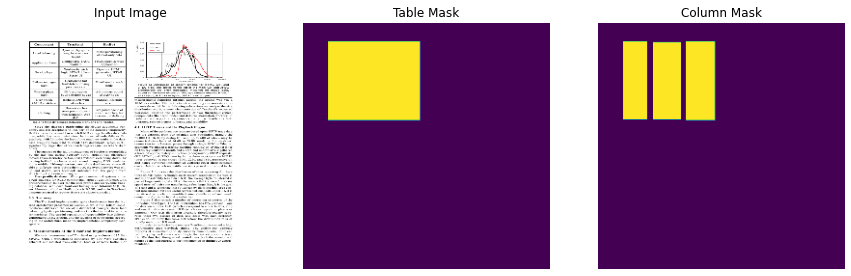

(256, 256, 3)
(256, 256, 1) (256, 256, 1)


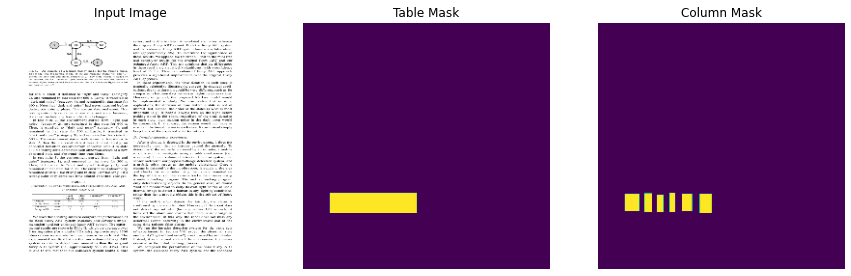

In [7]:
for image, mask in train.take(2):
  print(image.shape)
  print(mask['table_output'].shape, mask['column_output'].shape)
  
  display([image, mask['table_output'], mask['column_output']])

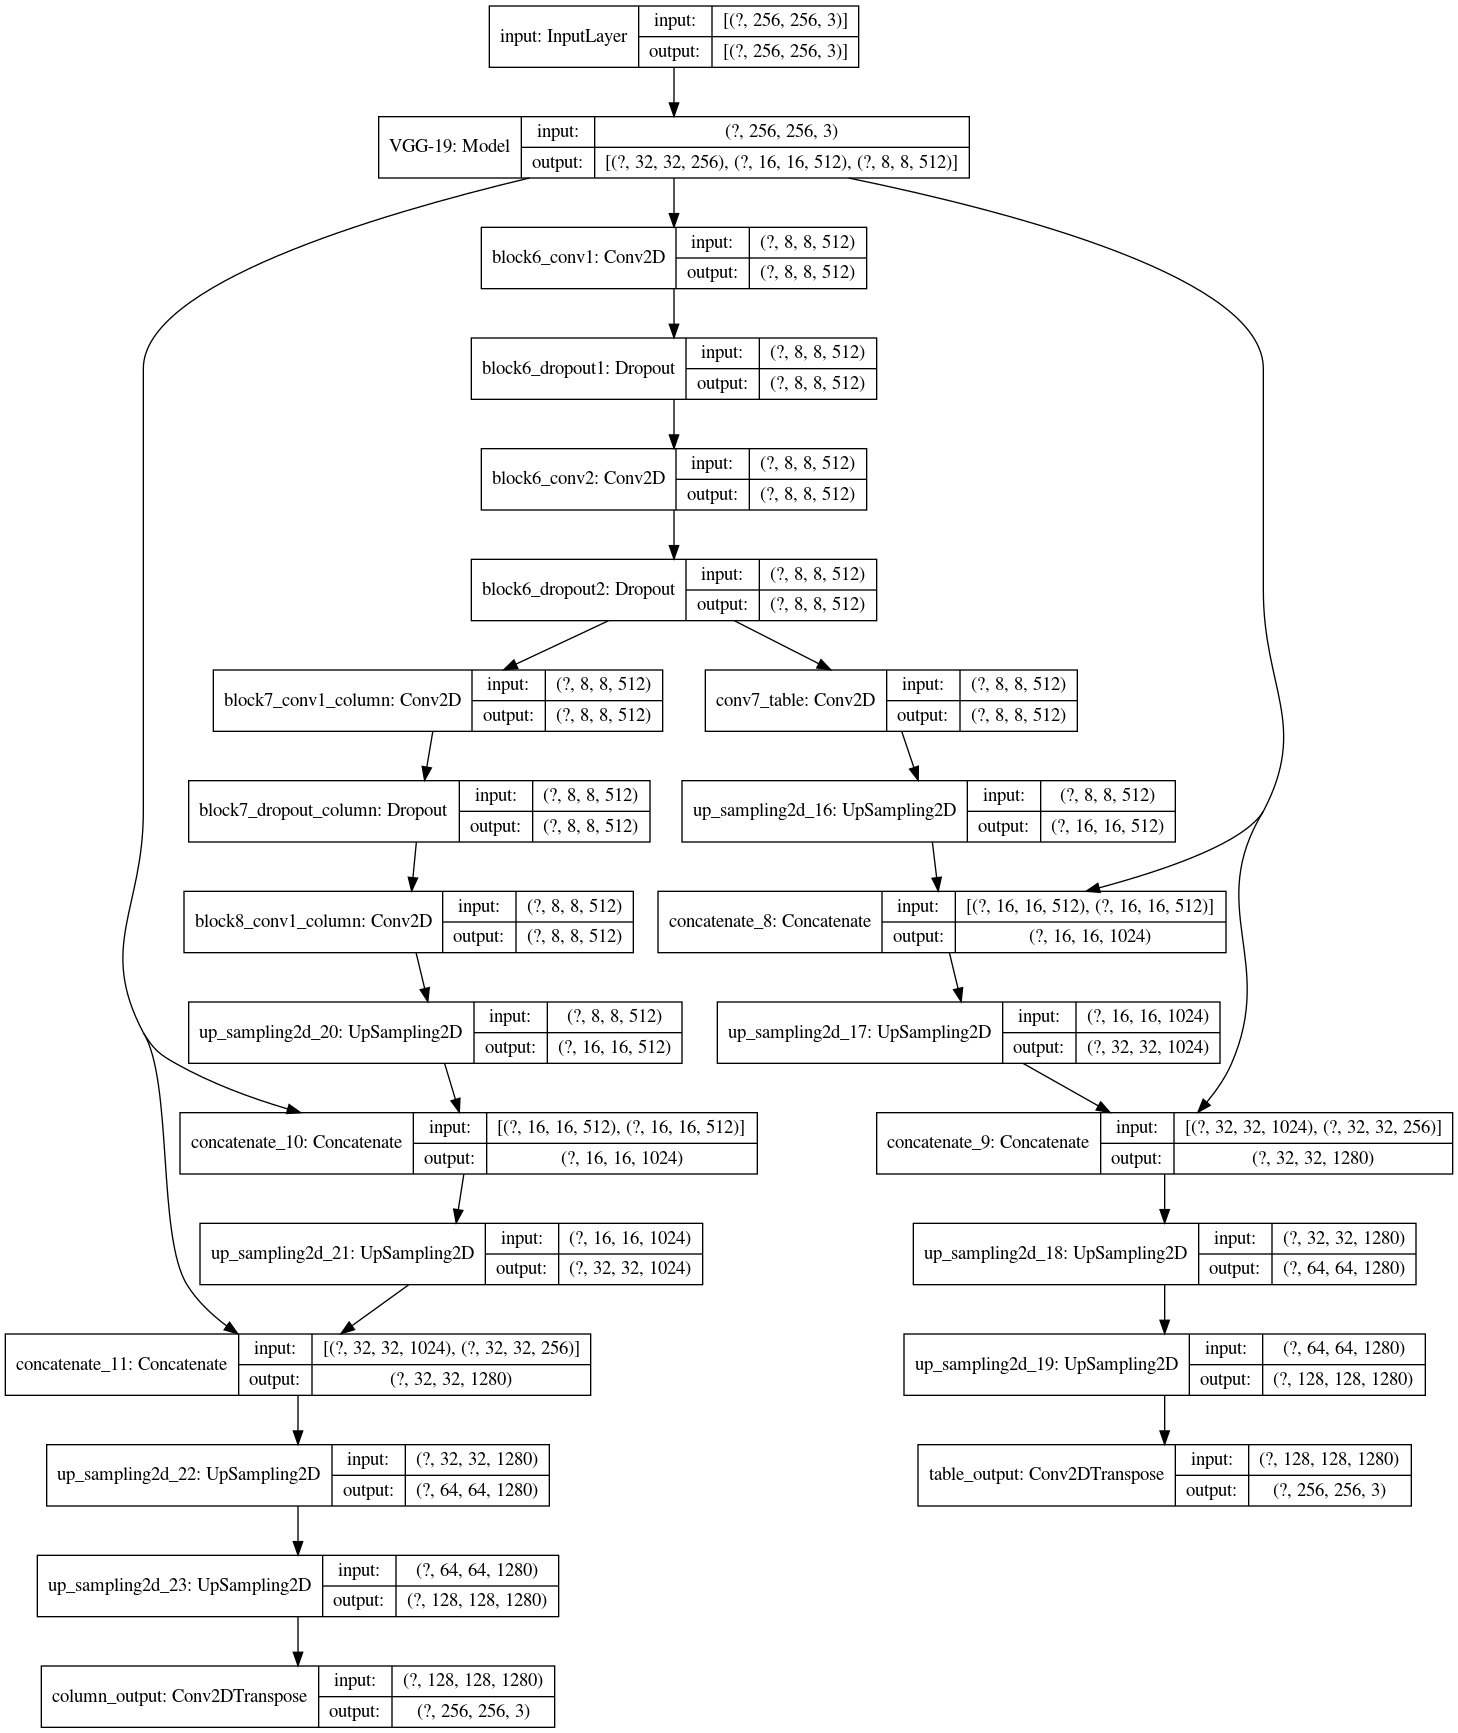

In [14]:
model = TableNet.build()
plot_model(model, show_shapes=True)

In [20]:
losses = {
	"table_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	"column_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table_output": 1.0, "column_output": 1.0}

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [21]:
def create_mask(pred_mask1, pred_mask2):
  pred_mask1 = tf.argmax(pred_mask1, axis=-1)
  pred_mask1 = pred_mask1[..., tf.newaxis]


  pred_mask2 = tf.argmax(pred_mask2, axis=-1)
  pred_mask2 = pred_mask2[..., tf.newaxis]
  return pred_mask1[0], pred_mask2[0]


In [22]:
for image, mask in train_dataset.take(1):
  sample_image, sample_mask1, sample_mask2 = image, mask['table_output'], mask['column_output']

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, (mask1, mask2) in dataset.take(num):
      pred_mask1, pred_mask2 = model.predict(image, verbose=1)
      table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
      
      display([image[0], table_mask, column_mask])
  else:
    pred_mask1, pred_mask2 = model.predict(sample_image, verbose=1)
    table_mask, column_mask = create_mask(pred_mask1, pred_mask2)

    display([sample_image[0], table_mask, column_mask])

##### Initial prediction from random weights initialization


1/1 [==============================] - 0s 1ms/step


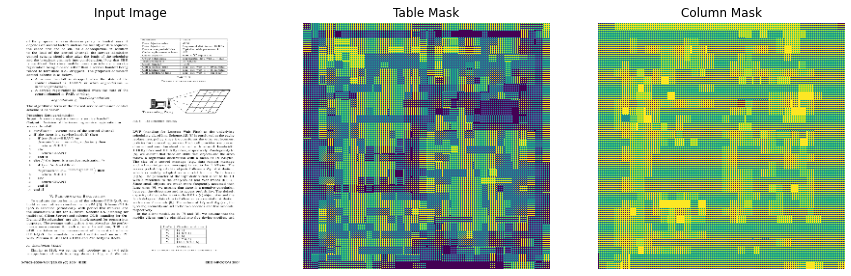

In [23]:
show_predictions(num=1)

In [26]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="model/model_{epoch}",
        save_best_only=True,
        monitor="val_loss",
        verbose=1,
    )

early_stoping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        verbose=1,
    )



1/1 [==============================] - 0s 1ms/step


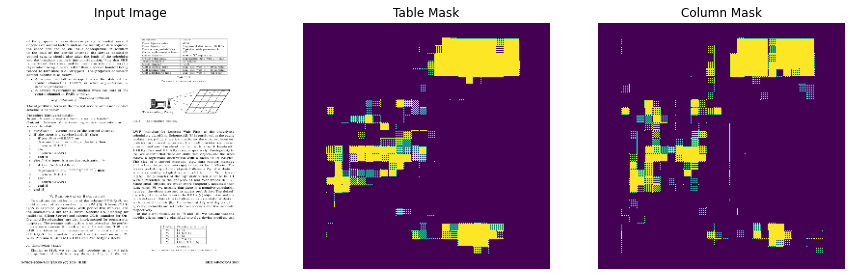


Sample Prediction after epoch 14


Epoch 00014: val_loss did not improve from 0.27940
222/222 [==============================] - 100s 449ms/step - loss: 0.3075 - table_output_loss: 0.1483 - column_output_loss: 0.1592 - table_output_accuracy: 0.9323 - column_output_accuracy: 0.9100 - val_loss: 0.4630 - val_table_output_loss: 0.2108 - val_column_output_loss: 0.2522 - val_table_output_accuracy: 0.9146 - val_column_output_accuracy: 0.8702
Epoch 00014: early stopping


In [30]:
EPOCHS = 500
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS


model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), model_checkpoint, early_stoping])

1/1 [==============================] - 0s 1ms/step


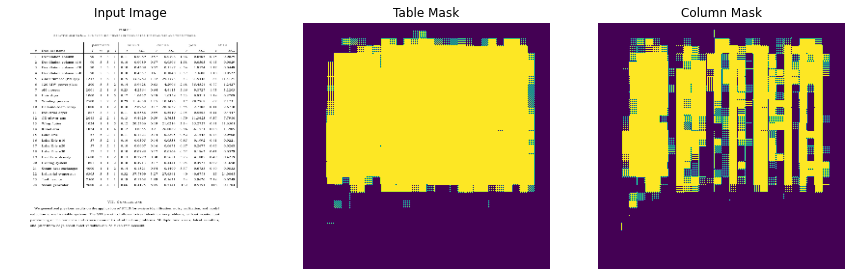

1/1 [==============================] - 0s 1ms/step


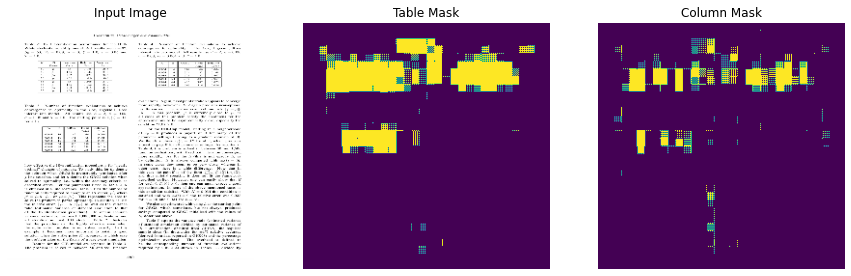

1/1 [==============================] - 0s 1ms/step


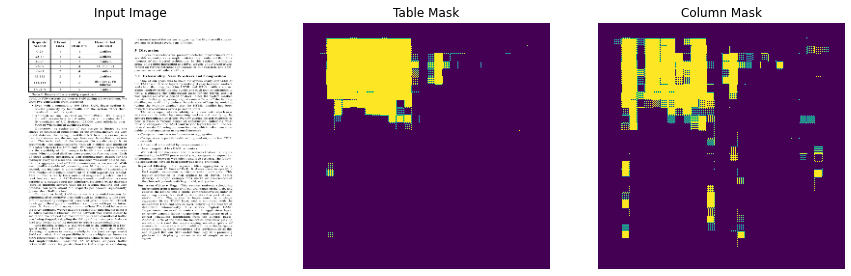

1/1 [==============================] - 0s 1ms/step


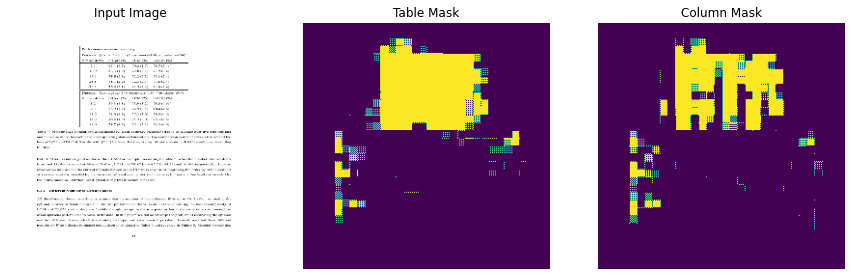

1/1 [==============================] - 0s 986us/step


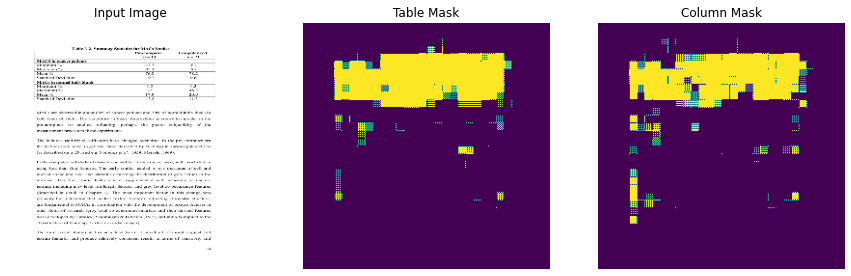

In [31]:
show_predictions(train_dataset, 5)

In [32]:
model.save('best_model')

INFO:tensorflow:Assets written to: best_model/assets


In [33]:
!zip -r best_model.zip best_model/


  adding: best_model/ (stored 0%)
  adding: best_model/saved_model.pb (deflated 91%)
  adding: best_model/assets/ (stored 0%)
  adding: best_model/variables/ (stored 0%)
  adding: best_model/variables/variables.index (deflated 73%)
  adding: best_model/variables/variables.data-00000-of-00001 (deflated 7%)


#### Apply Predicted Mask

In [ ]:
import cv2
import numpy as np

def impose_mask(org_img_path, mask_img_path, output_masked_img_path):
    INPUT_IMAGE1 = org_img_path
    INPUT_IMAGE2 = mask_img_path

    src1 = cv2.imread(INPUT_IMAGE1)
    src2 = cv2.imread(INPUT_IMAGE2)

    gray1 = cv2.cvtColor(src1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(src2, cv2.COLOR_BGR2GRAY)

    gray2 = cv2.resize(gray2, gray1.shape[1::-1])

    dst = cv2.bitwise_and(gray1, gray2)
    cv2.imwrite(output_masked_img_path,dst)

### OCR

In [ ]:
import cv2
import pytesseract as pt
from itertools import repeat
import csv

def extract(test_file_path, output_csv_path, output_text_path):
	image = cv2.imread(test_file_path)
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

	# Repair horizontal table lines 
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,1))
	thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

	# Remove horizontal lines
	horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (55,2))
	detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
	cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = cnts[0] if len(cnts) == 2 else cnts[1]
	for c in cnts:
	    cv2.drawContours(image, [c], -1, (255,255,255), 9)

	# Remove vertical lines
	vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,55))
	detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
	cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = cnts[0] if len(cnts) == 2 else cnts[1]
	for c in cnts:
	    cv2.drawContours(image, [c], -1, (255,255,255), 9)

	data = pt.image_to_string(image, lang='eng',config='--psm 6')
	print(data)
	with open(output_text_path, "w+") as f:
		f.write(data)

	with open(output_text_path, 'r') as in_file:
	    stripped = (line.strip() for line in in_file)
	    lines = (line.split("|") for line in stripped if line)
	    with open(output_csv_path, 'w') as out_file:
	        writer = csv.writer(out_file)
	        writer.writerow((' ', ' '))
	        writer.writerows(lines)


# from src.text_extract import extract
extract("dataset/test_data/sample.jpg", "dataset/test_data/sample_text.csv", "dataset/output/")